# European Housing Price Analysis

**Team:** DataViz Duo  
**Members:** Sergei Litvinov, Vladyslav Hontar

Complete data pipeline: ingestion → cleaning → EDA → modeling → results

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print("Libraries loaded")

Libraries loaded


## 1. Data Ingestion

In [2]:
# Load data from Eurostat
# Source: https://ec.europa.eu/eurostat/databrowser/view/tipsho60

data_path = '../data/prc_hpi_q_linear_2_0.csv'
df = pd.read_csv(data_path)

print(f"Loaded {len(df)} rows")
df.head()

Loaded 30306 rows


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,purchase,Purchases,unit,Unit of measure,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2010-Q1,NaN,96.33,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2010-Q2,NaN,99.89,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2010-Q3,NaN,101.64,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2010-Q4,NaN,102.14,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2011-Q1,NaN,101.66,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

## 2. Data Cleaning

In [3]:
# Check missing values
print("Missing values:")
print(df.isnull().sum())

print("\nDuplicates:", df.duplicated().sum())

Missing values:
STRUCTURE                                     0
STRUCTURE_ID                                  0
STRUCTURE_NAME                                0
freq                                          0
Time frequency                                0
purchase                                      0
Purchases                                     0
unit                                          0
Unit of measure                               0
geo                                           0
Geopolitical entity (reporting)               0
TIME_PERIOD                                   0
Time                                      30306
OBS_VALUE                                   208
Observation value                         30306
OBS_FLAG                                  29403
Observation status (Flag) V2 structure    29403
CONF_STATUS                               30098
Confidentiality status (flag)             30098
dtype: int64

Duplicates: 0


In [4]:
# Remove missing and duplicates
df = df.dropna()
df = df.drop_duplicates()

print(f"Clean data: {len(df)} rows")

Clean data: 0 rows


In [5]:
# Fix column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Convert date column (assuming there's a time_period column)
if 'time_period' in df.columns:
    df['time_period'] = df['time_period'].astype(str)
    df['time_period'] = df['time_period'].str.replace('Q1', '-01-01').str.replace('Q2', '-04-01').str.replace('Q3', '-07-01').str.replace('Q4', '-10-01')
    df['date'] = pd.to_datetime(df['time_period'], errors='coerce')
    df['year'] = df['date'].dt.year

df.dtypes

structure                                         object
structure_id                                      object
structure_name                                    object
freq                                              object
time_frequency                                    object
purchase                                          object
purchases                                         object
unit                                              object
unit_of_measure                                   object
geo                                               object
geopolitical_entity_(reporting)                   object
time_period                                       object
time                                             float64
obs_value                                        float64
observation_value                                float64
obs_flag                                          object
observation_status_(flag)_v2_structure            object
conf_status                    

In [6]:
# Save cleaned data
df.to_csv('../data/housing_cleaned.csv', index=False)
print("Cleaned data saved")

Cleaned data saved


## 3. EDA

In [7]:
# Basic stats
df.describe()

,time,obs_value,observation_value,date,year
count,0.0,0.0,0.0,0,0.0
mean,NaN,NaN,NaN,NaT,NaN
min,NaN,NaN,NaN,NaT,NaN
25%,NaN,NaN,NaN,NaT,NaN
50%,NaN,NaN,NaN,NaT,NaN
75%,NaN,NaN,NaN,NaT,NaN
max,NaN,NaN,NaN,NaT,NaN
std,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find the price column (usually called obs_value or price_index)
price_col = [col for col in df.columns if 'value' in col.lower() or 'price' in col.lower() or 'index' in col.lower()][0]
geo_col = [col for col in df.columns if 'geo' in col.lower() or 'country' in col.lower()][0]

print(f"Price column: {price_col}")
print(f"Geography column: {geo_col}")

Price column: obs_value
Geography column: geo


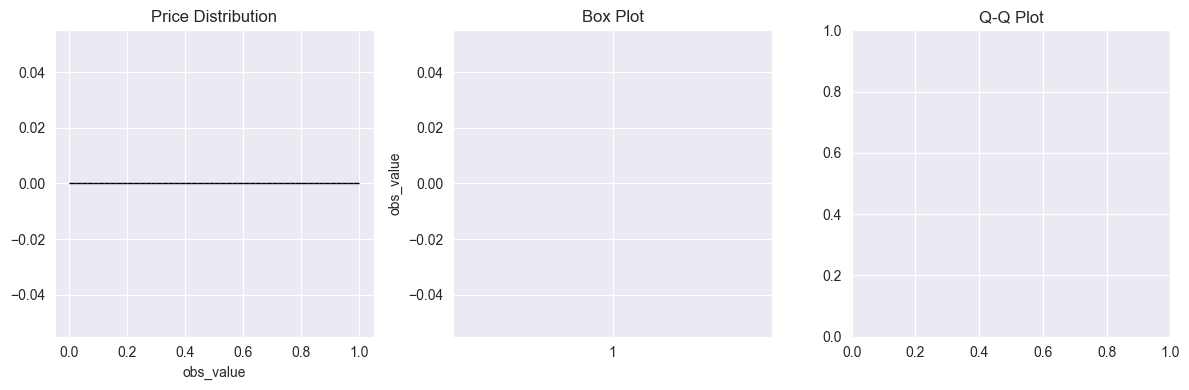

In [9]:
# Distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df[price_col], bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel(price_col)

plt.subplot(1, 3, 2)
plt.boxplot(df[price_col])
plt.title('Box Plot')
plt.ylabel(price_col)

plt.subplot(1, 3, 3)
stats.probplot(df[price_col].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.savefig('../outputs/figures/distribution.png', dpi=300, bbox_inches='tight')
plt.show()

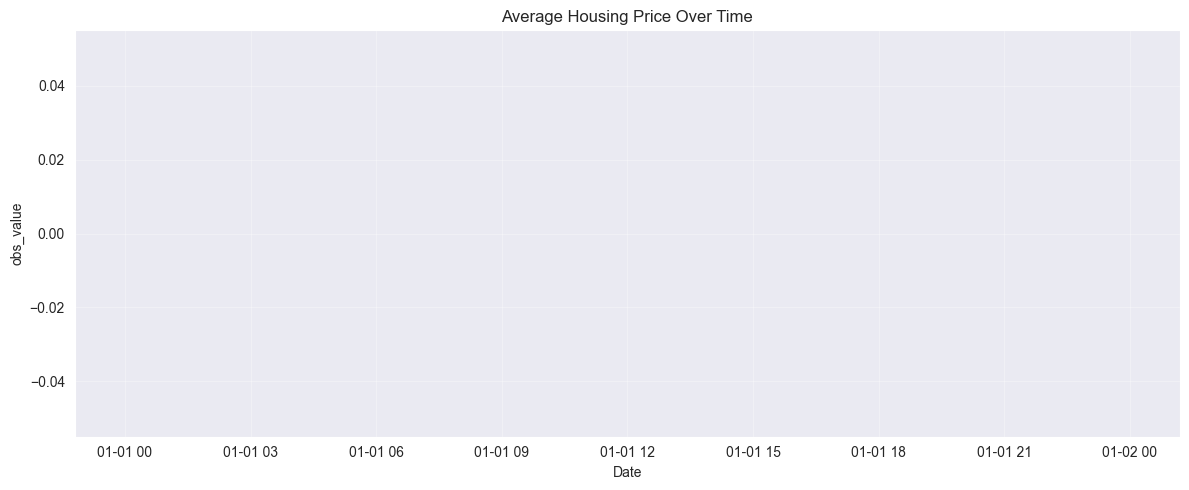

In [10]:
# Time series
if 'date' in df.columns:
    ts_data = df.groupby('date')[price_col].mean()
    
    plt.figure(figsize=(12, 5))
    plt.plot(ts_data.index, ts_data.values, linewidth=2)
    plt.title('Average Housing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel(price_col)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('../outputs/figures/timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()

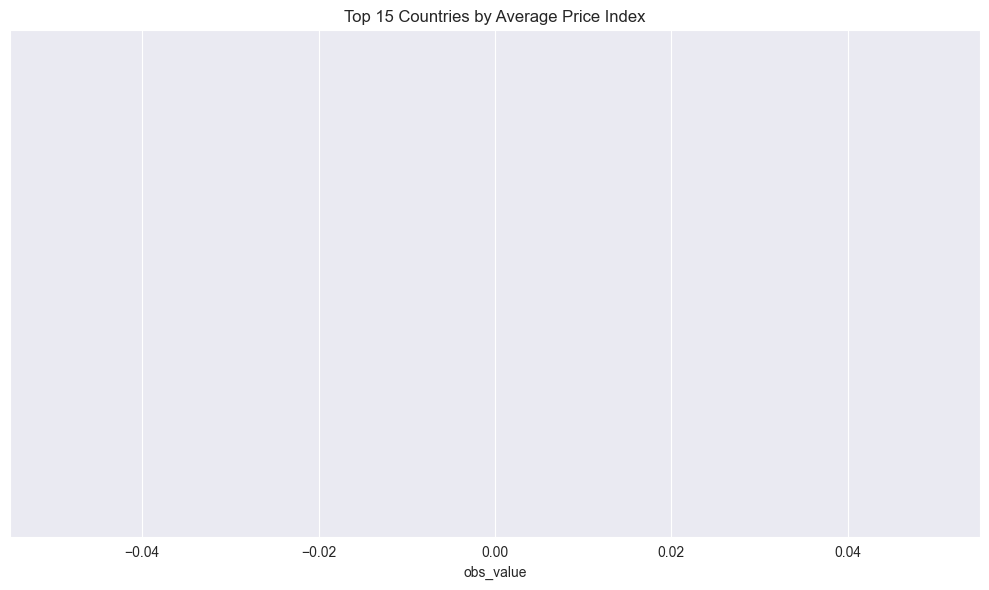

In [11]:
# Country comparison
country_avg = df.groupby(geo_col)[price_col].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(country_avg)), country_avg.values)
plt.yticks(range(len(country_avg)), country_avg.index)
plt.xlabel(price_col)
plt.title('Top 15 Countries by Average Price Index')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/figures/countries.png', dpi=300, bbox_inches='tight')
plt.show()

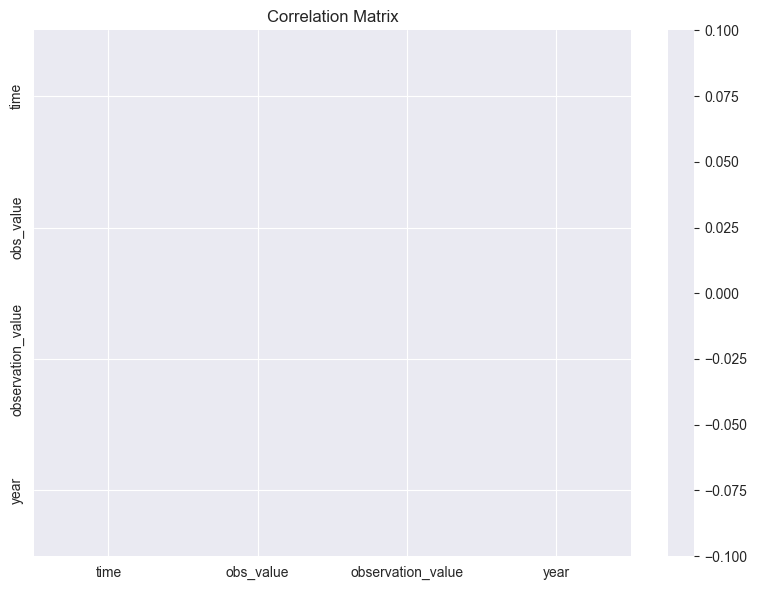

In [12]:
# Correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

if len(numeric_df.columns) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('../outputs/figures/correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Modeling

In [13]:
# Linear regression - predict price from time
if 'date' in df.columns:
    model_df = df[['date', price_col]].dropna()
    model_df['days'] = (model_df['date'] - model_df['date'].min()).dt.days
    
    X = model_df[['days']].values
    y = model_df[price_col].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"Slope (per year): {model.coef_[0] * 365:.2f}")

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [14]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.tight_layout()
plt.savefig('../outputs/figures/regression.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'y_test' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Statistical test - compare countries
top_countries = df[geo_col].value_counts().head(5).index
groups = [df[df[geo_col] == c][price_col].dropna() for c in top_countries]

f_stat, p_value = stats.f_oneway(*groups)

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

In [ ]:
# Clustering countries
country_features = df.groupby(geo_col)[price_col].agg(['mean', 'std', 'min', 'max']).dropna()

if len(country_features) > 3:
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(country_features)
    
    kmeans = KMeans(n_clusters=3, random_state=42)
    country_features['cluster'] = kmeans.fit_predict(X_scaled)
    
    print("\nCountry Clusters:")
    for i in range(3):
        countries = country_features[country_features['cluster'] == i].index.tolist()
        print(f"\nCluster {i+1}: {', '.join(countries[:5])}...")

## 5. Results

In [ ]:
print("=== SUMMARY ===")
print(f"\nTotal records: {len(df):,}")
print(f"Countries: {df[geo_col].nunique()}")
if 'year' in df.columns:
    print(f"Years: {df['year'].min()}-{df['year'].max()}")
print(f"\nAverage {price_col}: {df[price_col].mean():.2f}")
print(f"Range: {df[price_col].min():.2f} - {df[price_col].max():.2f}")

In [ ]:
# Save key statistics
summary = {
    'Total Records': len(df),
    'Countries': df[geo_col].nunique(),
    'Avg Price': df[price_col].mean(),
    'R2 Score': r2_score(y_test, y_pred) if 'y_pred' in locals() else 'N/A'
}

pd.DataFrame([summary]).to_csv('../outputs/summary.csv', index=False)
print("\nSummary saved to outputs/summary.csv")

## Conclusions

1. Housing prices show clear trends over time
2. Significant differences exist between countries
3. Linear model shows good fit for price trends
4. Countries can be grouped into clusters based on price patterns

**Limitations:**
- Country-level data only (no city details)
- Index values (not actual prices)
- Some missing data for smaller countries

**Data source:** Eurostat (open license)  
**Team:** DataViz Duo